# Comparing PSM3 and MERRA2 GHI

MERRA2 is a global weather reanalysis dataset providing, among other things, hourly GHI data. I'm not very familiar with MERRA2 and wanted to do a quick comparison with PSM3 (which I am quite familiar with) just to get a rough handle on how the two datasets compare when it comes to irradiance data.

Important notes if you want to run this notebook yourself:

- The username/password won't work for MERRA2 until you accept a EULA for it.
    + See https://disc.gsfc.nasa.gov/data-access and https://disc.gsfc.nasa.gov/earthdata-login
- The version of pydap on PyPI is pretty out of date, and we need a newer version with a bugfix.
    + See https://github.com/pydap/pydap/issues/121 and https://github.com/pydap/pydap/issues/212.
    + Install the current version with `pip install git+https://github.com/pydap/pydap#egg=pydap`
- SSL fails when connected to the NREL VPN, so disconnect before fetching data

In [11]:
from pydap.cas.urs import setup_session
import xarray as xr
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
# my favorite test location:
lat, lon = 40, -80
year = 2019

## MERRA2

pvlib will be getting a function to fetch MERRA2 data through Adam Jensen's GSoC project, but until then we'll DIY:

In [3]:
# credentials for EOSDIS/Earthdata
username = 'redacted'
password = 'redacted'

dataset = 'M2T1NXRAD'  # https://disc.gsfc.nasa.gov/datasets/M2T1NXRAD_5.12.4/summary
base = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/dods'
url = base + '/' + dataset

session = setup_session(username, password, check_url=url)
store = xr.backends.PydapDataStore.open(url, session=session)
ds = xr.open_dataset(store)
subset = ds.sel({'lat': lat, 'lon': lon, 'time': str(year)})
ghi_merra2 = subset['swgdn'].to_dataframe()  # short-wave global down, I assume?
ghi_merra2 = ghi_merra2['swgdn']

In [4]:
# clean up timestamps
ghi_merra2.index = ghi_merra2.index.round('30min')
ghi_merra2 = ghi_merra2.tz_localize('UTC')

## PSM3

In [5]:
# pvlib 0.8.1, the return values may swap places in a future version
meta, df = pvlib.iotools.get_psm3(lat, lon, 'DEMO_KEY', 'redacted', names=2019)
ghi_psm3 = df['GHI']

## Comparison

It's a pretty close match when both models predict clear-sky conditions, but not always a great match otherwise.  MERRA2 might be less "jagged" than PSM3.

<AxesSubplot:>

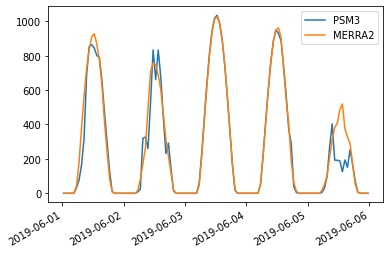

In [7]:
df = pd.DataFrame({
    'PSM3': ghi_psm3,
    'MERRA2': ghi_merra2,
})
df = df.tz_convert(ghi_psm3.index.tz)
df.loc['2019-06-01':'2019-06-05'].plot()

<AxesSubplot:>

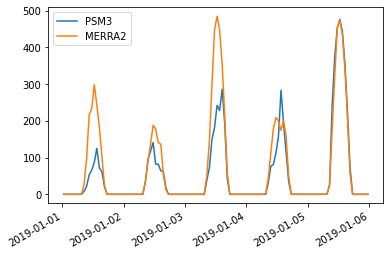

In [8]:
df.loc['2019-01-01':'2019-01-05'].plot()

<AxesSubplot:>

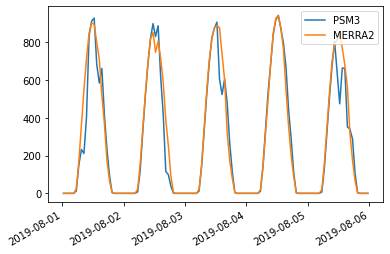

In [9]:
df.loc['2019-08-01': '2019-08-05'].plot()

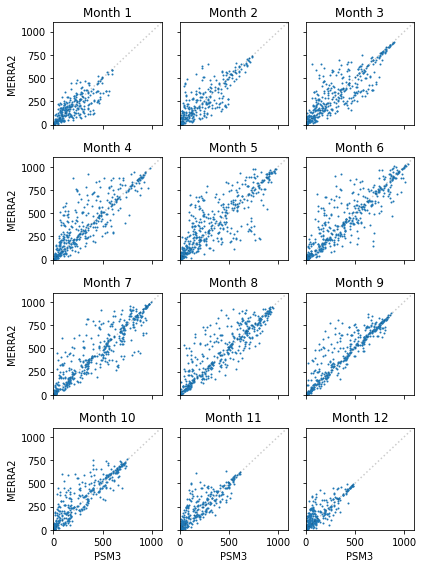

In [23]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(6, 8))
axes = axes.ravel()
for i, month in enumerate(range(1, 13)):
    df.loc[f'2019-{month}'].plot.scatter('PSM3', 'MERRA2', title=f'Month {month}', s=1, ax=axes[i])
    axes[i].axline((0, 0), (1, 1), c='k', ls=':', alpha=0.2)

axes[0].set_xlim(0, 1100)
axes[0].set_ylim(0, 1100)

fig.tight_layout()

Seems like, for this location anyway, the scatter of MERRA2 relative to PSM3 tends to bias high.  And the difference in total insolation for 2019 is significant:

In [19]:
sums = df.sum()
ratio = sums['MERRA2'] / sums['PSM3']
ratio

1.0881261835174243